Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Experiment Management with ClearML

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/unet_segmentation_3d_ignite.ipynb)

This tutorial shows how to use ClearML to manage MONAI experiments. You can integrate ClearML into your code using Monai's built-in handlers: `ClearMLImageHandler`, `ClearMLStatsHandler`, and `ModelCheckpoint`.

The MONAI example used here is [3D segmentation with UNet](https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/unet_segmentation_3d_ignite.ipynb).

## Setup environment

`clearml` comes as part of the `monai[all]` installation. For more information about integrating ClearML into your Monai code, see [here](https://clear.ml/docs/latest/docs/integrations/monai). For more information about using ClearML (experiment management, data management, pipelines, model serving, and more), see [ClearML's official documentation](https://clear.ml/docs/latest/docs/).

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[ignite, nibabel, tensorboard, clearml]"

### Set up ClearML ⚓

1. To keep track of your experiments and/or data, ClearML needs to communicate to a server. You have 2 server options:

  * Sign up for free to the [ClearML Hosted Service](https://app.clear.ml/)
  * Set up your own server, see [here](https://clear.ml/docs/latest/docs/deploying_clearml/clearml_server).



2. Add you ClearML credentials below. ClearML will use these credentials to connect to your server (see instructions for generating credentials [here](https://clear.ml/docs/latest/docs/getting_started/ds/ds_first_steps/#jupyter-notebook)).

In [ ]:
# clearml credentials
%env CLEARML_WEB_HOST=''
%env CLEARML_API_HOST=''
%env CLEARML_FILES_HOST=''
%env CLEARML_API_ACCESS_KEY=''
%env CLEARML_API_SECRET_KEY=''


## Setup imports

In [ ]:
import glob
import logging
import os
from pathlib import Path
import shutil
import sys
import tempfile

import nibabel as nib
import numpy as np
from monai.config import print_config
from monai.data import ArrayDataset, create_test_image_3d, decollate_batch, DataLoader
from monai.handlers import (
    MeanDice,
    StatsHandler,
)
# import the clearml handlers
from monai.handlers.clearml_handlers import ClearMLImageHandler, ClearMLStatsHandler
from monai.losses import DiceLoss
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandSpatialCrop,
    Resize,
    ScaleIntensity,
)
from monai.utils import first

import ignite
import torch
print_config()

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

## Setup logging

In [ ]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Setup demo data

In [ ]:
for i in range(40):
    im, seg = create_test_image_3d(128, 128, 128, num_seg_classes=1)

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"im{i}.nii.gz"))

    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"seg{i}.nii.gz"))

images = sorted(glob.glob(os.path.join(root_dir, "im*.nii.gz")))
segs = sorted(glob.glob(os.path.join(root_dir, "seg*.nii.gz")))

## Setup transforms, dataset

In [ ]:
# Define transforms for image and segmentation
imtrans = Compose(
    [
        LoadImage(image_only=True),
        ScaleIntensity(),
        EnsureChannelFirst(),
        RandSpatialCrop((96, 96, 96), random_size=False),
    ]
)
segtrans = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        RandSpatialCrop((96, 96, 96), random_size=False),
    ]
)

# Define nifti dataset, dataloader
ds = ArrayDataset(images, imtrans, segs, segtrans)
# loader = DataLoader(ds, batch_size=10, num_workers=2, pin_memory=torch.cuda.is_available())
loader = DataLoader(ds, batch_size=10, num_workers=2, pin_memory=False)
im, seg = first(loader)
print(im.shape, seg.shape)

## Create Model, Loss, Optimizer

In [ ]:
# Create UNet, DiceLoss and Adam optimizer

device = None # torch.device("cuda:0")
net = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss = DiceLoss(sigmoid=True)
lr = 1e-3
opt = torch.optim.Adam(net.parameters(), lr)

## Create supervised_trainer using ignite

In [ ]:
# Create trainer
trainer = ignite.engine.create_supervised_trainer(net, opt, loss, device, False)

## Set up event handlers for checkpointing and logging

Using a ClearML handler creates a ClearML Task, which captures your experiment's models, scalars, images, and more.

The console output displays the task ID and a link to the task's page in the ClearML web UI.

In [ ]:
# optional section for checkpoint and clearml logging
# adding checkpoint handler to save models (network
# params and optimizer stats) during training
log_dir = os.path.join(root_dir, "logs")
checkpoint_handler = ignite.handlers.ModelCheckpoint(log_dir, "net", n_saved=10, require_empty=False)
trainer.add_event_handler(
    event_name=ignite.engine.Events.EPOCH_COMPLETED,
    handler=checkpoint_handler,
    to_save={"net": net, "opt": opt},
)

# StatsHandler prints loss at every iteration
# user can also customize print functions and can use output_transform to convert
# engine.state.output if it's not a loss value
train_stats_handler = StatsHandler(name="trainer", output_transform=lambda x: x)
train_stats_handler.attach(trainer)


# ClearMLStatsHandler plots loss at every iteration
# Creates a ClearML Task which logs the scalar plots
task_name = "UNet segmentation 3d"
project_name = "Monai example"

train_clearml_stats_handler = ClearMLStatsHandler(task_name=task_name,
     project_name=project_name, log_dir=log_dir, output_transform=lambda x: x)
train_clearml_stats_handler.attach(trainer)


## Add Validation every N epochs

In [ ]:
# optional section for model validation during training
validation_every_n_epochs = 1
# Set parameters for validation
metric_name = "Mean_Dice"
# add evaluation metric to the evaluator engine
val_metrics = {metric_name: MeanDice()}
post_pred = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
post_label = Compose([AsDiscrete(threshold=0.5)])
# Ignite evaluator expects batch=(img, seg) and
# returns output=(y_pred, y) at every iteration,
# user can add output_transform to return other values
evaluator = ignite.engine.create_supervised_evaluator(
    net,
    val_metrics,
    device,
    True,
    output_transform=lambda x, y, y_pred: (
        [post_pred(i) for i in decollate_batch(y_pred)],
        [post_label(i) for i in decollate_batch(y)],
    ),
)

# create a validation data loader
val_imtrans = Compose(
    [
        LoadImage(image_only=True),
        ScaleIntensity(),
        EnsureChannelFirst(),
        Resize((96, 96, 96)),
    ]
)
val_segtrans = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        Resize((96, 96, 96)),
    ]
)
val_ds = ArrayDataset(images[21:], val_imtrans, segs[21:], val_segtrans)
# val_loader = DataLoader(val_ds, batch_size=5, num_workers=8, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_ds, batch_size=5, num_workers=8, pin_memory=False)


@trainer.on(ignite.engine.Events.EPOCH_COMPLETED(every=validation_every_n_epochs))
def run_validation(engine):
    evaluator.run(val_loader)


# Add stats event handler to print validation stats via evaluator
val_stats_handler = StatsHandler(
    name="evaluator",
    # no need to print loss value, so disable per iteration output
    output_transform=lambda x: None,
    # fetch global epoch number from trainer
    global_epoch_transform=lambda x: trainer.state.epoch,
)
val_stats_handler.attach(evaluator)

# add handler to record metrics to clearml at every validation epoch
val_clearml_stats_handler = ClearMLStatsHandler(
    log_dir=log_dir,
    # no need to plot loss value, so disable per iteration output
    output_transform=lambda x: None,
    # fetch global epoch number from trainer
    global_epoch_transform=lambda x: trainer.state.epoch,
)
val_clearml_stats_handler.attach(evaluator)

# add handler to draw the first image and the corresponding
# label and model output in the last batch
# here we draw the 3D output as GIF format along Depth
# axis, at every validation epoch
val_clearml_image_handler = ClearMLImageHandler(task_name=task_name,
    project_name=project_name,
    log_dir=log_dir,
    batch_transform=lambda batch: (batch[0], batch[1]),
    output_transform=lambda output: output[0],
    global_iter_transform=lambda x: trainer.state.epoch,
)
evaluator.add_event_handler(
    event_name=ignite.engine.Events.EPOCH_COMPLETED,
    handler=val_clearml_image_handler,
)

## Run training loop

In [ ]:
# create a training data loader
train_ds = ArrayDataset(images[:20], imtrans, segs[:20], segtrans)
train_loader = DataLoader(
    train_ds,
    batch_size=5,
    shuffle=True,
    num_workers=8,
    # pin_memory=torch.cuda.is_available(),
    pin_memory=False
)

max_epochs = 10
trainer.run(train_loader, max_epochs)

## Visualize results

ClearML captures the models, scalar plots, and images logged with `ModelCheckpoint`, `ClearMLImageHandler`, and `ClearMLStatsHandler` respectively. View them in ClearML's web UI. When a task is created, the console output displays the task ID and a link to the task's page in the ClearML web UI.

### Models
All model checkpoints logged with ModelCheckpoint can be viewed in the task's **Artifacts** tab.





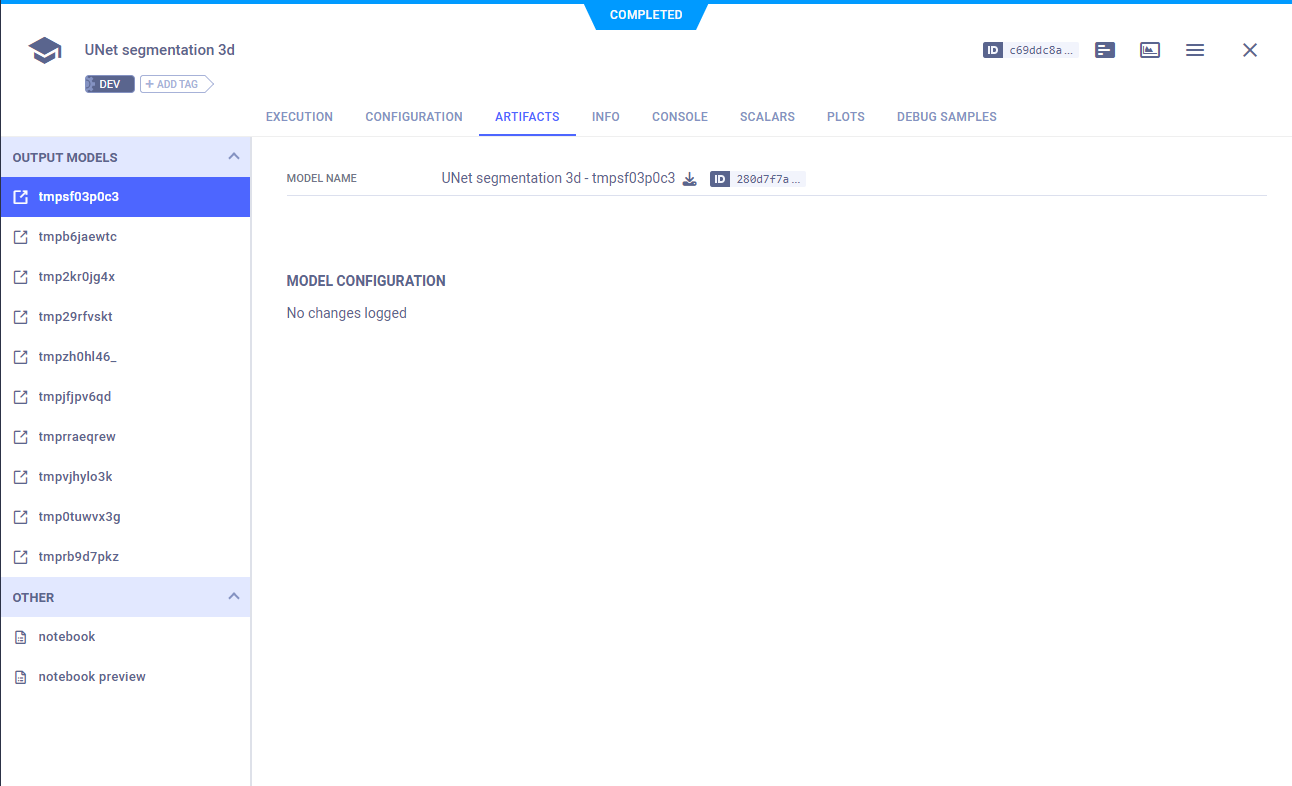

### Scalars

View the logged metric plots in the task's **Scalars** tab.



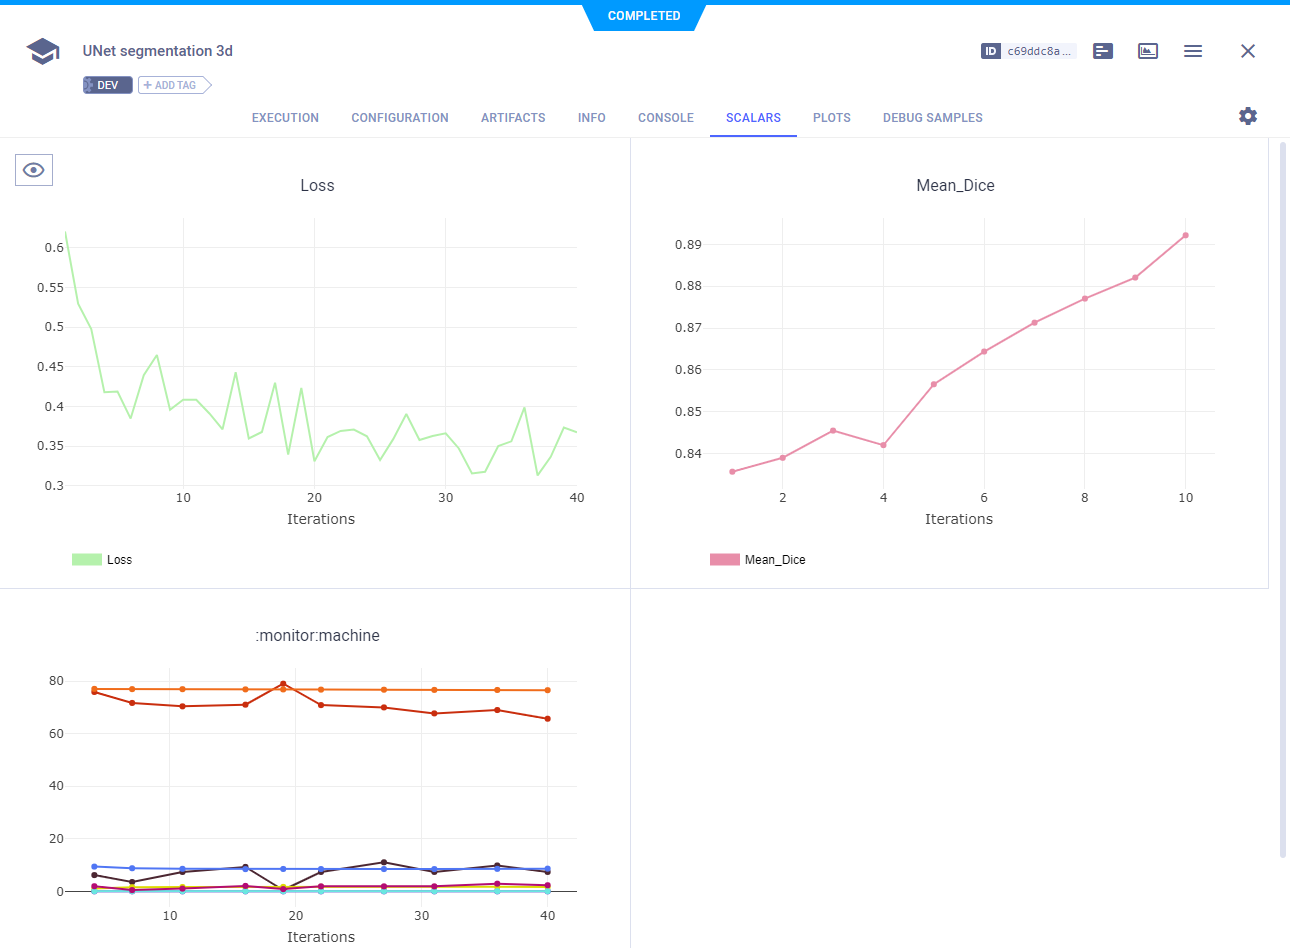

### Debug Samples

View all images logged through ClearMLImageHandler in the task's **Debug Samples** tab. You can view the samples by metric at any iteration.

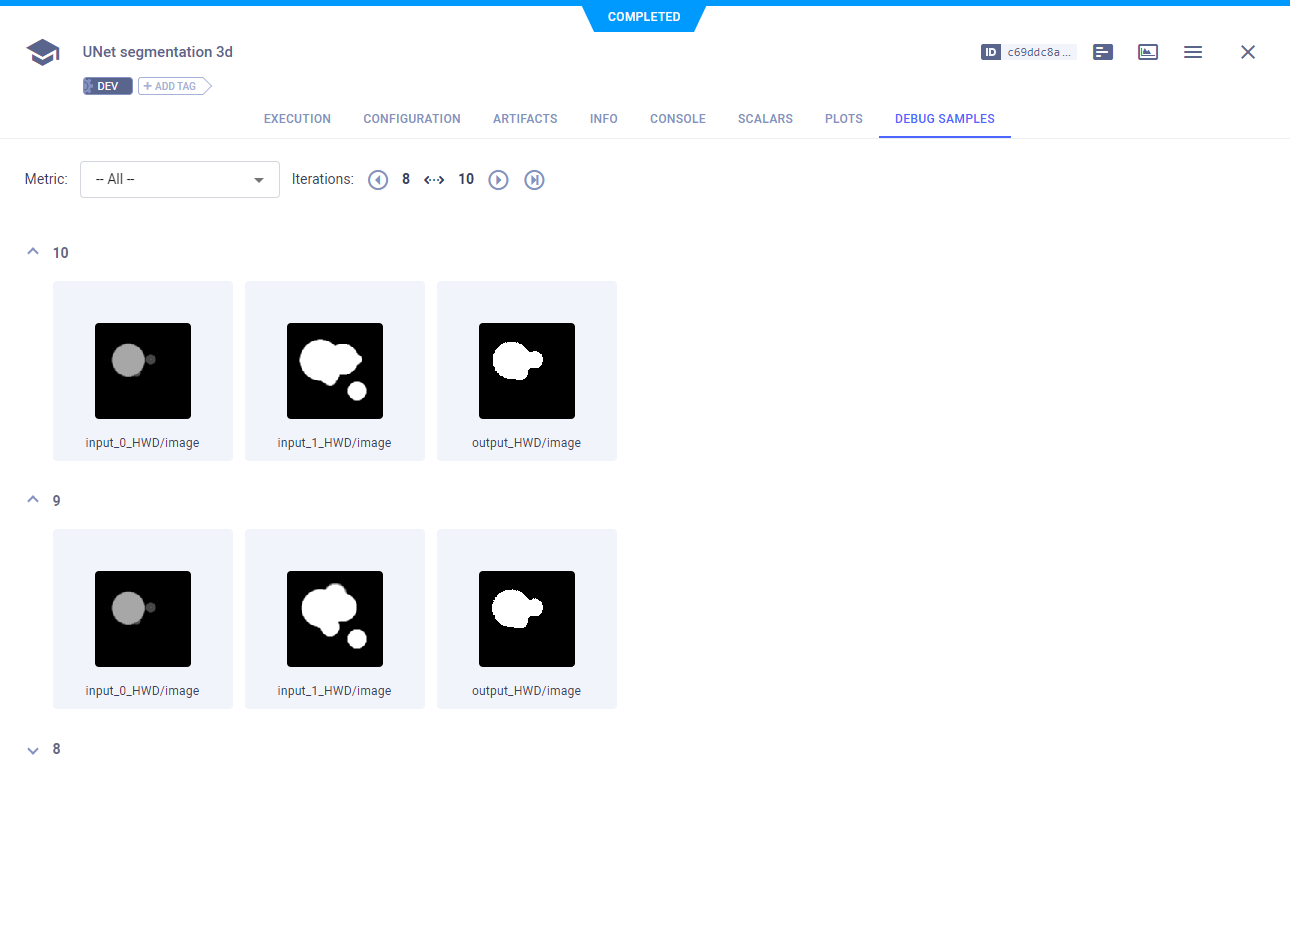

## Cleanup data directory

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)


## Close the ClearML Task
This changes the task status to `Completed`.

In [ ]:
val_clearml_image_handler.clearml_task.close()